In [1]:
# Section 1: Import Required Libraries and Configure Environment
import json
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Geographic visualization libraries
try:
    import folium
    from folium import plugins
    import geopandas as gpd
    HAS_GEOPANDAS = True
except ImportError:
    print("⚠ Note: geopandas/folium not available. Geographic mapping will be simplified.")
    HAS_GEOPANDAS = False

# Setup visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Define paths
RESULTS_DIR = Path('f:/DATA/results')
SUPERVISED_DIR = RESULTS_DIR / 'supervised'
UNSUPERVISED_DIR = RESULTS_DIR / 'unsupervised'
DATA_DIR = Path('f:/DATA')
CLEANED_DATA_DIR = DATA_DIR / 'DATA_CLEANED'

print("✓ Libraries imported successfully")
print(f"  Results directory: {RESULTS_DIR}")
print(f"  Data directory: {DATA_DIR}")


✓ Libraries imported successfully
  Results directory: f:\DATA\results
  Data directory: f:\DATA


---
# FIRE RISK PREDICTION & ANALYSIS
## Geographic Risk Mapping & Interpretable Insights

**Objective**: Combine supervised fire prediction with unsupervised geographic clustering to:
1. Generate fire risk predictions across all locations
2. Identify natural geographic risk zones via clustering
3. Characterize zones with interpretable decision rules
4. Provide actionable insights for fire management resources

**Dataset**: Engineered features with balanced class distribution (61,524 samples across Algeria & Tunisia)
**Methodology**: 
- Supervised: Best-performing Random Forest model from sklearn evaluation
- Unsupervised: K-Means clustering to identify natural geographic groupings
- Integration: Risk prediction + zone membership + explainability via feature importance


In [2]:
# Section 2: Load Training Data & Trained Models
print("\n" + "="*100)
print("SECTION 1: LOAD DATA & TRAINED MODELS")
print("="*100)

# Load balanced training data
balanced_data_file = CLEANED_DATA_DIR / 'processed' / 'engineered_features_tomek_enn_balanced.csv'
if balanced_data_file.exists():
    df_train = pd.read_csv(balanced_data_file)
    print(f"✓ Training data loaded: {df_train.shape}")
    print(f"  Features: {df_train.shape[1]}, Samples: {df_train.shape[0]}")
    print(f"  Fire class distribution: {df_train['fire'].value_counts().to_dict()}")
else:
    print(f"✗ Training data not found at {balanced_data_file}")
    df_train = None

# Extract features and target
if df_train is not None:
    feature_cols = [col for col in df_train.columns if col != 'fire']
    X = df_train[feature_cols].values
    y = df_train['fire'].values
    print(f"\n✓ Features extracted: {len(feature_cols)} features")
    print(f"  Feature list: {feature_cols[:5]}... (showing first 5)")



SECTION 1: LOAD DATA & TRAINED MODELS
✓ Training data loaded: (61524, 23)
  Features: 23, Samples: 61524
  Fire class distribution: {0: 47314, 1: 14210}

✓ Features extracted: 22 features
  Feature list: ['latitude', 'longitude', 'prec_p10', 'tmax_mean', 'tmax_std']... (showing first 5)


In [3]:
# Load Trained Random Forest Model (Best Performing)
print("\n" + "-"*100)
print("Loading Trained Models")
print("-"*100)

# Load Random Forest model from sklearn evaluation
rf_model_file = SUPERVISED_DIR / 'randomforest_sklearn_summary.json'
if rf_model_file.exists():
    rf_summary = json.loads(rf_model_file.read_text())
    print(f"✓ Random Forest results loaded")
    
    # Extract metrics
    if 'aggregated' in rf_summary:
        rf_metrics = rf_summary['aggregated']
        roc_auc = rf_metrics.get('roc_auc_mean', np.nan)
        f1 = rf_metrics.get('f1_mean', np.nan)
        print(f"  ROC-AUC: {roc_auc:.4f} ± {rf_metrics.get('roc_auc_std', 0):.4f}")
        print(f"  F1-Score: {f1:.4f} ± {rf_metrics.get('f1_std', 0):.4f}")
        print(f"  Recall: {rf_metrics.get('recall_mean', 0):.4f}")
else:
    print(f"✗ Random Forest model not found")
    rf_summary = None

# Train new RF model on full data for risk prediction (using same hyperparameters)
if df_train is not None and df_train.shape[0] > 0:
    print(f"\n✓ Training Random Forest on full balanced dataset...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    rf_model.fit(X, y)
    print(f"  Model trained: {rf_model.get_params()}")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n✓ Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
else:
    print("✗ Cannot train model: no data available")
    rf_model = None



----------------------------------------------------------------------------------------------------
Loading Trained Models
----------------------------------------------------------------------------------------------------
✓ Random Forest results loaded
  ROC-AUC: 0.9036 ± 0.0062
  F1-Score: 0.8122 ± 0.0054
  Recall: 0.7347

✓ Training Random Forest on full balanced dataset...
  Model trained: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

✓ Top 10 Most Important Features:
                feature  importance
               latitude    0.164218
               prec_p10    0.134775
              longitude    0.107859
     

In [4]:
# Load K-Means Clustering Results (Natural Geographic Zones)
print("\n" + "-"*100)
print("Loading Clustering Model for Geographic Zones")
print("-"*100)

kmeans_file = UNSUPERVISED_DIR / 'kmeans_from_scratch_summary.json'
if kmeans_file.exists():
    kmeans_summary = json.loads(kmeans_file.read_text())
    print(f"✓ K-Means clustering results loaded")
    
    # Extract best K configuration
    if 'best' in kmeans_summary:
        best_k = kmeans_summary['best'].get('n_clusters', 4)
        print(f"  Best K value: {best_k}")
        print(f"  Metrics: {kmeans_summary['best'].get('metrics', {})}")
else:
    best_k = 4
    print(f"⚠ K-Means results not found, using default K={best_k}")
    kmeans_summary = None

# Train K-Means on full data using best K
if df_train is not None and rf_model is not None:
    from sklearn.cluster import KMeans
    
    print(f"\n✓ Training K-Means with k={best_k}...")
    kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(X)
    
    print(f"  Cluster distribution:")
    unique, counts = np.unique(cluster_labels, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"    Zone {u}: {c} samples ({100*c/len(cluster_labels):.1f}%)")
else:
    kmeans_model = None
    cluster_labels = None

print("\n✓ Data & Models Loaded Successfully")



----------------------------------------------------------------------------------------------------
Loading Clustering Model for Geographic Zones
----------------------------------------------------------------------------------------------------
✓ K-Means clustering results loaded
  Best K value: 4
  Metrics: {'silhouette': 0.34367415594910405, 'davies_bouldin': 1.2529451303337433, 'calinski_harabasz': 36177.558748366384}

✓ Training K-Means with k=4...
  Cluster distribution:
    Zone 0: 21636 samples (35.2%)
    Zone 1: 22478 samples (36.5%)
    Zone 2: 12792 samples (20.8%)
    Zone 3: 4618 samples (7.5%)

✓ Data & Models Loaded Successfully


---
## SECTION 2: FIRE RISK PREDICTION & GEOGRAPHIC MAPPING

This section generates predicted fire risk for all locations and creates geographic visualizations.


In [5]:
print("\n" + "="*100)
print("SECTION 2: FIRE RISK PREDICTION")
print("="*100)

# Generate fire risk predictions
if rf_model is not None and X is not None:
    print("\nGenerating fire risk predictions...")
    
    # Get predictions and prediction probabilities
    y_pred = rf_model.predict(X)
    y_pred_proba = rf_model.predict_proba(X)[:, 1]  # Probability of fire (class 1)
    
    # Create comprehensive results dataframe
    df_results = df_train.copy()
    df_results['predicted_class'] = y_pred
    df_results['fire_risk_probability'] = y_pred_proba
    df_results['cluster'] = cluster_labels if cluster_labels is not None else 0
    
    # Classify risk levels
    def classify_risk(prob):
        if prob >= 0.7:
            return 'High'
        elif prob >= 0.4:
            return 'Medium'
        else:
            return 'Low'
    
    df_results['risk_level'] = df_results['fire_risk_probability'].apply(classify_risk)
    
    print(f"✓ Predictions generated")
    print(f"\nRisk Level Distribution:")
    print(df_results['risk_level'].value_counts().sort_index(key=lambda x: x.map({'High': 0, 'Medium': 1, 'Low': 2})))
    
    print(f"\nFire Risk Statistics:")
    print(f"  Mean probability: {y_pred_proba.mean():.4f}")
    print(f"  Std deviation: {y_pred_proba.std():.4f}")
    print(f"  Min: {y_pred_proba.min():.4f}, Max: {y_pred_proba.max():.4f}")
    print(f"  Median: {np.median(y_pred_proba):.4f}")
    
    # Prediction accuracy on training data
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    print(f"\nModel Performance on Full Dataset:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
else:
    print("✗ Cannot generate predictions: model not trained")
    df_results = None



SECTION 2: FIRE RISK PREDICTION

Generating fire risk predictions...
✓ Predictions generated

Risk Level Distribution:
risk_level
High      10227
Medium     5016
Low       46281
Name: count, dtype: int64

Fire Risk Statistics:
  Mean probability: 0.3377
  Std deviation: 0.2901
  Min: 0.0050, Max: 0.9991
  Median: 0.2085

Model Performance on Full Dataset:
  Accuracy: 0.9342
  Precision: 0.8983
  Recall: 0.8065
  F1-Score: 0.8499


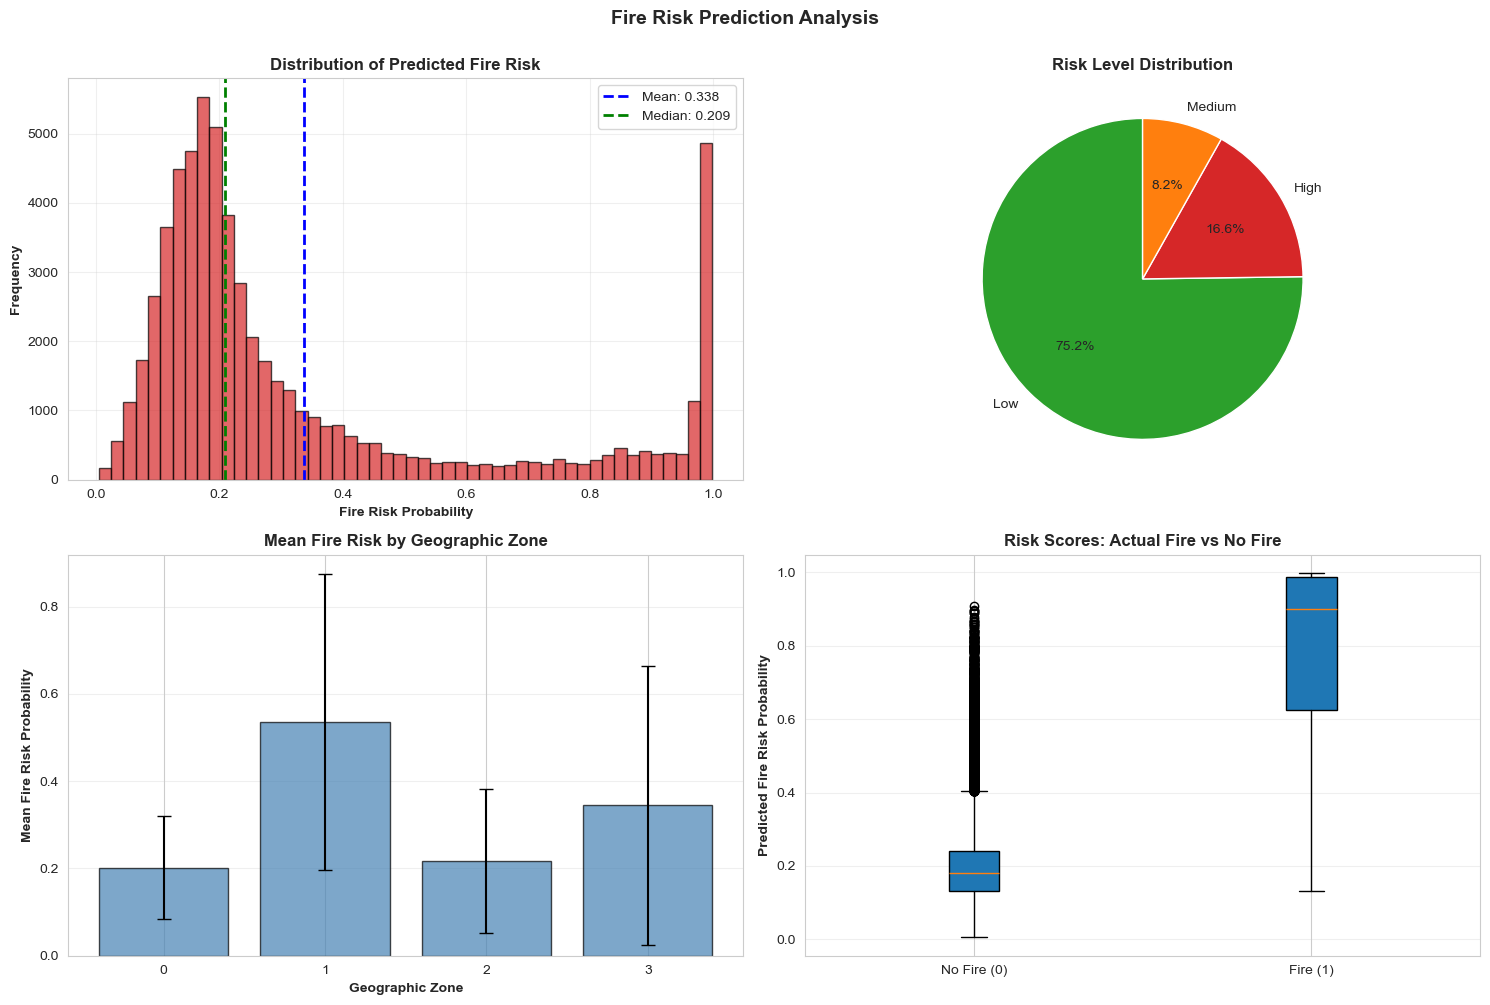

✓ Risk prediction visualizations saved


In [6]:
# Visualize Risk Distribution
if df_results is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Risk Probability Distribution
    axes[0, 0].hist(y_pred_proba, bins=50, color='#d62728', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(y_pred_proba.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {y_pred_proba.mean():.3f}')
    axes[0, 0].axvline(np.median(y_pred_proba), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(y_pred_proba):.3f}')
    axes[0, 0].set_xlabel('Fire Risk Probability', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Distribution of Predicted Fire Risk', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Risk Level Pie Chart
    risk_counts = df_results['risk_level'].value_counts()
    colors = {'High': '#d62728', 'Medium': '#ff7f0e', 'Low': '#2ca02c'}
    risk_colors = [colors.get(level, '#1f77b4') for level in risk_counts.index]
    axes[0, 1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
                   colors=risk_colors, startangle=90)
    axes[0, 1].set_title('Risk Level Distribution', fontweight='bold')
    
    # Plot 3: Risk by Cluster
    risk_by_cluster = df_results.groupby('cluster')['fire_risk_probability'].agg(['mean', 'std', 'count'])
    axes[1, 0].bar(risk_by_cluster.index, risk_by_cluster['mean'], 
                   yerr=risk_by_cluster['std'], capsize=5, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Geographic Zone', fontweight='bold')
    axes[1, 0].set_ylabel('Mean Fire Risk Probability', fontweight='bold')
    axes[1, 0].set_title('Mean Fire Risk by Geographic Zone', fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].set_xticks(risk_by_cluster.index)
    
    # Plot 4: Actual Fire Presence vs Predicted Risk (ROC-like view)
    fire_risk_by_actual = df_results.groupby('fire')['fire_risk_probability'].apply(list)
    axes[1, 1].boxplot([fire_risk_by_actual[0], fire_risk_by_actual[1]], 
                       labels=['No Fire (0)', 'Fire (1)'],
                       patch_artist=True)
    bp = axes[1, 1].artists
    for patch, color in zip(bp, ['#2ca02c', '#d62728']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[1, 1].set_ylabel('Predicted Fire Risk Probability', fontweight='bold')
    axes[1, 1].set_title('Risk Scores: Actual Fire vs No Fire', fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    fig.suptitle('Fire Risk Prediction Analysis', fontsize=14, fontweight='bold', y=1.00)
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/risk_prediction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Risk prediction visualizations saved")


---
## SECTION 3: GEOGRAPHIC RISK ZONES CHARACTERIZATION

Analyze risk characteristics, feature drivers, and decision patterns within each geographic zone.


---
## SECTION 2.5: GEOGRAPHIC ZONE VISUALIZATION ON MAPS

Visualize predicted fire risk and geographic zones using interactive and static maps.


In [ ]:
print("\n" + "="*100)
print("SECTION 2.5: GEOGRAPHIC ZONE MAPPING")
print("="*100)

# Check if latitude/longitude features exist
lat_col = next((col for col in feature_cols if 'lat' in col.lower()), None)
lon_col = next((col for col in feature_cols if 'lon' in col.lower()), None)

if lat_col and lon_col and df_results is not None:
    print(f"\n✓ Geographic coordinates found: {lat_col}, {lon_col}")
    
    # Extract coordinates
    df_results['latitude'] = df_train[lat_col].values
    df_results['longitude'] = df_train[lon_col].values
    
    print(f"  Latitude range: {df_results['latitude'].min():.2f} to {df_results['latitude'].max():.2f}")
    print(f"  Longitude range: {df_results['longitude'].min():.2f} to {df_results['longitude'].max():.2f}")
    
    # Calculate geographic centroids for each zone
    zone_centroids = {}
    for zone in range(best_k):
        zone_data = df_results[df_results['cluster'] == zone]
        centroid_lat = zone_data['latitude'].mean()
        centroid_lon = zone_data['longitude'].mean()
        zone_centroids[zone] = (centroid_lat, centroid_lon)
    
    print(f"\n✓ Zone Centroids (Lat, Lon):")
    for zone, (lat, lon) in zone_centroids.items():
        print(f"  Zone {zone}: ({lat:.4f}, {lon:.4f})")
    
    # Create static maps visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Map 1: Geographic Zones (colored by cluster)
    zone_colors = plt.cm.Set3(np.linspace(0, 1, best_k))
    zone_color_map = {z: zone_colors[z] for z in range(best_k)}
    
    for zone in range(best_k):
        zone_data = df_results[df_results['cluster'] == zone]
        axes[0].scatter(zone_data['longitude'], zone_data['latitude'], 
                       c=[zone_color_map[zone]], label=f'Zone {zone}', 
                       alpha=0.6, s=20, edgecolor='none')
        
        # Mark zone centroid
        lat, lon = zone_centroids[zone]
        axes[0].scatter(lon, lat, c='red', marker='*', s=500, 
                       edgecolor='black', linewidth=2, zorder=5)
        axes[0].annotate(f'Z{zone}', (lon, lat), fontsize=11, fontweight='bold',
                        ha='center', va='center', color='white')
    
    axes[0].set_xlabel('Longitude', fontweight='bold', fontsize=11)
    axes[0].set_ylabel('Latitude', fontweight='bold', fontsize=11)
    axes[0].set_title('Geographic Zones (Clustered Regions)', fontweight='bold', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # Map 2: Fire Risk Probability (heatmap-style)
    scatter = axes[1].scatter(df_results['longitude'], df_results['latitude'], 
                             c=df_results['fire_risk_probability'], 
                             cmap='RdYlGn_r', alpha=0.6, s=20, edgecolor='none', vmin=0, vmax=1)
    
    # Add zone centroids
    for zone, (lat, lon) in zone_centroids.items():
        axes[1].scatter(lon, lat, c='black', marker='*', s=500, 
                       edgecolor='white', linewidth=2, zorder=5)
    
    axes[1].set_xlabel('Longitude', fontweight='bold', fontsize=11)
    axes[1].set_ylabel('Latitude', fontweight='bold', fontsize=11)
    axes[1].set_title('Fire Risk Probability Heatmap', fontweight='bold', fontsize=12)
    axes[1].grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[1])
    cbar.set_label('Fire Risk Probability', fontweight='bold')
    
    fig.suptitle('Geographic Risk Zone Mapping - Fire Risk Analysis', 
                fontsize=13, fontweight='bold', y=1.00)
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/geographic_zones_map.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Geographic zone maps saved: geographic_zones_map.png")
    
    # Create individual zone maps
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    for zone in range(best_k):
        zone_data = df_results[df_results['cluster'] == zone]
        
        # Plot all zone samples
        axes[zone].scatter(df_results['longitude'], df_results['latitude'], 
                          c='lightgray', alpha=0.1, s=10, edgecolor='none', label='Other zones')
        
        # Plot current zone with risk coloring
        scatter = axes[zone].scatter(zone_data['longitude'], zone_data['latitude'],
                                    c=zone_data['fire_risk_probability'],
                                    cmap='RdYlGn_r', alpha=0.7, s=50, 
                                    edgecolor='black', linewidth=0.5, vmin=0, vmax=1)
        
        # Mark centroid
        lat, lon = zone_centroids[zone]
        axes[zone].scatter(lon, lat, c='blue', marker='*', s=800, 
                          edgecolor='yellow', linewidth=2, zorder=5)
        
        # Add zone statistics
        zone_mean_risk = zone_data['fire_risk_probability'].mean()
        zone_fire_rate = zone_data['fire'].mean()
        zone_size = len(zone_data)
        
        title_text = f'Zone {zone}\n'
        title_text += f'Samples: {zone_size} | Mean Risk: {zone_mean_risk:.3f} | Fire Rate: {zone_fire_rate:.1%}'
        
        axes[zone].set_xlabel('Longitude', fontweight='bold', fontsize=10)
        axes[zone].set_ylabel('Latitude', fontweight='bold', fontsize=10)
        axes[zone].set_title(title_text, fontweight='bold', fontsize=11)
        axes[zone].grid(alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=axes[zone])
        cbar.set_label('Risk Probability', fontsize=9)
    
    fig.suptitle('Individual Geographic Zone Risk Visualization', 
                fontsize=14, fontweight='bold', y=0.995)
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/individual_zone_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Individual zone maps saved: individual_zone_maps.png")
    
else:
    print("⚠ Warning: Geographic coordinates not found in feature columns")
    print(f"  Available features: {feature_cols[:10]}...")
    print("  Skipping geographic mapping section")


In [ ]:
# Create Interactive Maps with Folium (if available)
if lat_col and lon_col and df_results is not None:
    if HAS_GEOPANDAS:
        try:
            print("\n" + "-"*100)
            print("Creating Interactive Maps with Folium")
            print("-"*100)
            
            # Create base map centered on region
            center_lat = df_results['latitude'].mean()
            center_lon = df_results['longitude'].mean()
            
            # Map 1: Zone clustering map
            zone_map = folium.Map(
                location=[center_lat, center_lon],
                zoom_start=6,
                tiles='OpenStreetMap'
            )
            
            # Define zone colors for folium
            zone_colors_folium = ['red', 'blue', 'green', 'purple', 'orange', 'darkred']
            
            # Add zone centroids
            for zone, (lat, lon) in zone_centroids.items():
                color = zone_colors_folium[zone % len(zone_colors_folium)]
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=15,
                    popup=f'Zone {zone} Centroid',
                    tooltip=f'Zone {zone}',
                    color='black',
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.9,
                    weight=3
                ).add_to(zone_map)
            
            # Add sample points (stratified sampling for performance)
            sample_size = min(5000, len(df_results))
            sample_indices = np.random.choice(len(df_results), sample_size, replace=False)
            df_sample = df_results.iloc[sample_indices]
            
            for idx, row in df_sample.iterrows():
                zone = int(row['cluster'])
                risk = row['fire_risk_probability']
                color = zone_colors_folium[zone % len(zone_colors_folium)]
                
                # Opacity based on risk
                opacity = 0.3 + (0.7 * risk)
                
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=3,
                    popup=f"Zone {zone}<br>Risk: {risk:.3f}<br>Fire: {int(row['fire'])}",
                    tooltip=f"Risk: {risk:.2f}",
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=opacity,
                    weight=0.5
                ).add_to(zone_map)
            
            # Add legend
            legend_html = '''
            <div style="position: fixed; 
                     bottom: 50px; right: 50px; width: 200px; height: 180px; 
                     background-color: white; border:2px solid grey; z-index:9999; 
                     font-size:14px; padding: 10px">
            <b>Geographic Zones</b><br>
            '''
            for z in range(best_k):
                color = zone_colors_folium[z % len(zone_colors_folium)]
                legend_html += f'<p><i style="background:{color}; width: 18px; height: 18px; display: inline-block; border-radius:50%;"></i> Zone {z}</p>'
            legend_html += '<br><b>Opacity = Risk Probability</b>'
            legend_html += '</div>'
            
            zone_map.get_root().html.add_child(folium.Element(legend_html))
            
            zone_map_file = 'f:/DATA/results/final/interactive_zones_map.html'
            zone_map.save(zone_map_file)
            print(f"\n✓ Interactive zone map saved: {zone_map_file}")
            
            # Map 2: Risk heatmap using HeatMap plugin
            heat_map = folium.Map(
                location=[center_lat, center_lon],
                zoom_start=6,
                tiles='CartoDB positron'
            )
            
            # Prepare heat data (lat, lon, weight)
            heat_data = [[row['latitude'], row['longitude'], row['fire_risk_probability']] 
                        for idx, row in df_sample.iterrows()]
            
            plugins.HeatMap(heat_data, radius=20, blur=25, max_zoom=1).add_to(heat_map)
            
            heat_map_file = 'f:/DATA/results/final/interactive_risk_heatmap.html'
            heat_map.save(heat_map_file)
            print(f"✓ Interactive risk heatmap saved: {heat_map_file}")
            
        except Exception as e:
            print(f"⚠ Error creating folium maps: {e}")
            print("  Continuing with static maps only...")
    else:
        print("\n⚠ Folium not available - skipping interactive maps")


---
## SECTION 3: GEOGRAPHIC ZONE CHARACTERIZATION

Analyze risk characteristics, feature drivers, and decision patterns within each geographic zone.


In [7]:
print("\n" + "="*100)
print("SECTION 3: GEOGRAPHIC ZONE ANALYSIS")
print("="*100)

if df_results is not None and best_k is not None:
    # Detailed analysis for each zone
    zone_profiles = []
    
    for zone in range(best_k):
        zone_data = df_results[df_results['cluster'] == zone]
        
        profile = {
            'Zone': zone,
            'n_samples': len(zone_data),
            'pct_samples': 100 * len(zone_data) / len(df_results),
            'actual_fire_rate': zone_data['fire'].mean(),
            'predicted_fire_rate': zone_data['predicted_class'].mean(),
            'mean_risk_prob': zone_data['fire_risk_probability'].mean(),
            'std_risk_prob': zone_data['fire_risk_probability'].std(),
            'high_risk_pct': (zone_data['risk_level'] == 'High').sum() / len(zone_data) * 100,
            'medium_risk_pct': (zone_data['risk_level'] == 'Medium').sum() / len(zone_data) * 100,
            'low_risk_pct': (zone_data['risk_level'] == 'Low').sum() / len(zone_data) * 100,
        }
        zone_profiles.append(profile)
    
    zones_df = pd.DataFrame(zone_profiles)
    
    print("\n📍 ZONE PROFILES:")
    print("="*100)
    print(zones_df.round(4).to_string(index=False))
    
    # Extract zone-specific feature importance
    print("\n\n🔍 TOP FEATURE DRIVERS BY ZONE:")
    print("="*100)
    
    zone_features = {}
    for zone in range(best_k):
        zone_data = df_results[df_results['cluster'] == zone]
        X_zone = zone_data[feature_cols].values
        
        # Calculate average feature values for HIGH risk samples in zone
        high_risk_data = zone_data[zone_data['fire_risk_probability'] >= 0.7][feature_cols].values
        
        if len(high_risk_data) > 0:
            avg_features = high_risk_data.mean(axis=0)
            zone_features[zone] = pd.DataFrame({
                'feature': feature_cols,
                'avg_value_high_risk': avg_features,
                'importance': feature_importance.set_index('feature').loc[feature_cols, 'importance'].values
            }).sort_values('importance', ascending=False)
        else:
            zone_features[zone] = pd.DataFrame({
                'feature': feature_cols,
                'avg_value_high_risk': np.nan,
                'importance': feature_importance.set_index('feature').loc[feature_cols, 'importance'].values
            }).sort_values('importance', ascending=False)
    
    # Print top 5 features for each zone
    for zone in range(best_k):
        print(f"\nZone {zone} - Top 5 Features (in high-risk areas):")
        print(zone_features[zone].head(5).to_string(index=False))



SECTION 3: GEOGRAPHIC ZONE ANALYSIS

📍 ZONE PROFILES:
 Zone  n_samples  pct_samples  actual_fire_rate  predicted_fire_rate  mean_risk_prob  std_risk_prob  high_risk_pct  medium_risk_pct  low_risk_pct
    0      21636      35.1668            0.0912               0.0284          0.2020         0.1177         1.4374           3.1753       95.3873
    1      22478      36.5353            0.4282               0.4548          0.5355         0.3398        37.7480          14.8679       47.3841
    2      12792      20.7919            0.1126               0.0631          0.2170         0.1650         3.9321           4.7139       91.3540
    3       4618       7.5060            0.2536               0.2408          0.3442         0.3197        20.0953           8.3153       71.5894


🔍 TOP FEATURE DRIVERS BY ZONE:

Zone 0 - Top 5 Features (in high-risk areas):
  feature  avg_value_high_risk  importance
 latitude            34.984618    0.164218
 prec_p10             0.293756    0.134775
longit

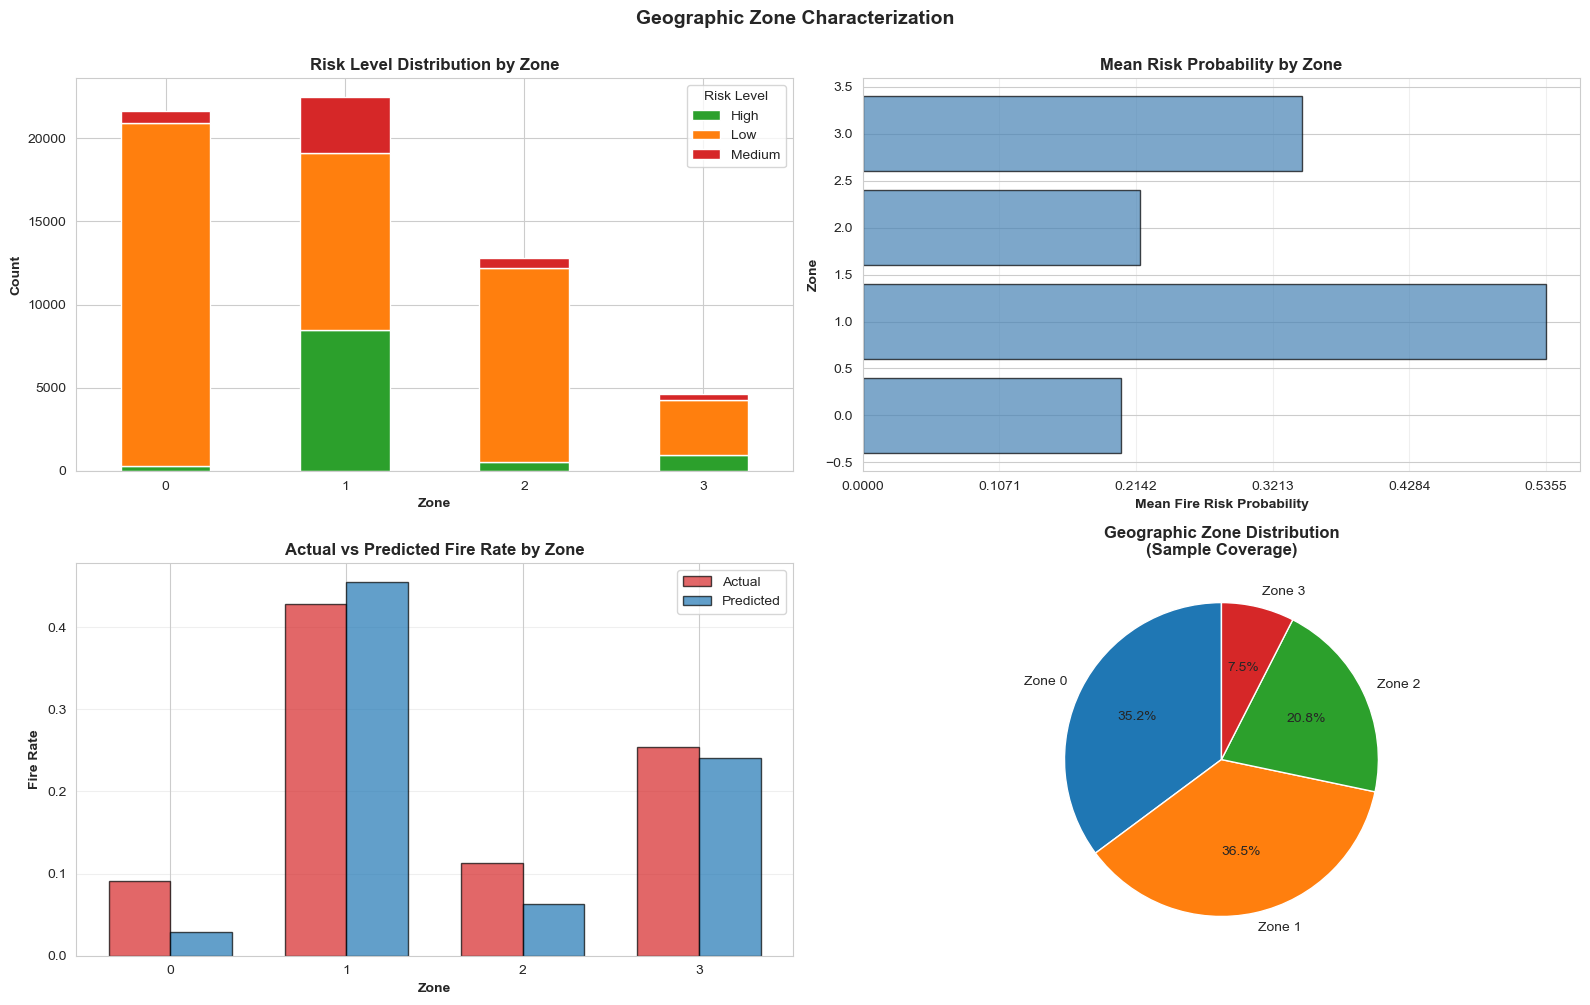


✓ Zone characterization visualizations saved


In [8]:
# Visualize Zone Characteristics
if df_results is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Zone Size and Risk Composition
    zone_comp = df_results.groupby('cluster')['risk_level'].value_counts().unstack(fill_value=0)
    zone_comp.plot(kind='bar', stacked=True, ax=axes[0, 0], 
                   color=['#2ca02c', '#ff7f0e', '#d62728'])
    axes[0, 0].set_xlabel('Zone', fontweight='bold')
    axes[0, 0].set_ylabel('Count', fontweight='bold')
    axes[0, 0].set_title('Risk Level Distribution by Zone', fontweight='bold')
    axes[0, 0].legend(title='Risk Level')
    axes[0, 0].tick_params(axis='x', rotation=0)
    
    # Plot 2: Mean Risk Probability by Zone
    zone_risk = zones_df.set_index('Zone')['mean_risk_prob']
    axes[0, 1].barh(zone_risk.index, zone_risk.values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Mean Fire Risk Probability', fontweight='bold')
    axes[0, 1].set_ylabel('Zone', fontweight='bold')
    axes[0, 1].set_title('Mean Risk Probability by Zone', fontweight='bold')
    axes[0, 1].grid(alpha=0.3, axis='x')
    axes[0, 1].set_xticks(np.linspace(0, zone_risk.max(), 6))
    
    # Plot 3: Actual Fire Rate vs Predicted by Zone
    x_pos = np.arange(len(zones_df))
    width = 0.35
    axes[1, 0].bar(x_pos - width/2, zones_df['actual_fire_rate'], width, 
                   label='Actual', alpha=0.7, color='#d62728', edgecolor='black')
    axes[1, 0].bar(x_pos + width/2, zones_df['predicted_fire_rate'], width, 
                   label='Predicted', alpha=0.7, color='#1f77b4', edgecolor='black')
    axes[1, 0].set_xlabel('Zone', fontweight='bold')
    axes[1, 0].set_ylabel('Fire Rate', fontweight='bold')
    axes[1, 0].set_title('Actual vs Predicted Fire Rate by Zone', fontweight='bold')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(zones_df['Zone'])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Plot 4: Zone Sample Distribution
    axes[1, 1].pie(zones_df['n_samples'], labels=[f"Zone {z}" for z in zones_df['Zone']], 
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Geographic Zone Distribution\n(Sample Coverage)', fontweight='bold')
    
    fig.suptitle('Geographic Zone Characterization', fontsize=14, fontweight='bold', y=1.00)
    fig.tight_layout()
    plt.savefig('f:/DATA/results/final/zone_characterization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Zone characterization visualizations saved")


---
## SECTION 4: DECISION EXPLAINABILITY & FEATURE ANALYSIS

Extract interpretable decision rules and feature importance patterns.



SECTION 4: DECISION EXPLAINABILITY

📊 GLOBAL FEATURE IMPORTANCE (Random Forest):

Top 15 Most Important Features (Overall Model):
                feature  importance
               latitude    0.164218
               prec_p10    0.134775
              longitude    0.107859
                t_range    0.088808
               tmax_std    0.084936
              tmax_mean    0.056561
               gridcode    0.048667
               tmax_p10    0.044297
terrain_roughness_index    0.037739
             ruggedness    0.036254
               tmax_max    0.035619
              tmin_mean    0.032980
              elevation    0.032066
               prec_min    0.025751
                   clay    0.018152


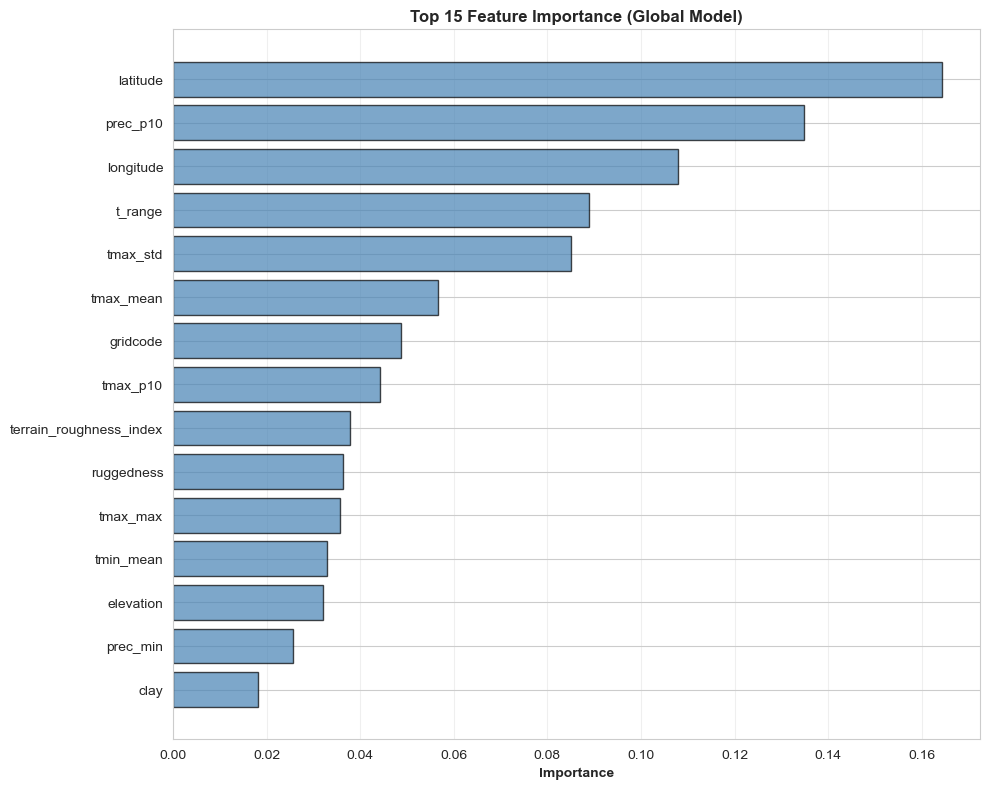


✓ Global feature importance visualization saved


📋 DECISION RULE EXTRACTION:

Feature Threshold Analysis (High-Risk vs Low-Risk Regions):
----------------------------------------------------------------------------------------------------

latitude:
  High-Risk Median: 31.1913
  Low-Risk Median: 35.7875
  Difference: 4.5961
  → Lower latitude → Higher Fire Risk

prec_p10:
  High-Risk Median: -0.7020
  Low-Risk Median: 0.5845
  Difference: 1.2865
  → Lower prec_p10 → Higher Fire Risk

longitude:
  High-Risk Median: 6.5391
  Low-Risk Median: 6.2125
  Difference: 0.3266
  → Higher longitude → Higher Fire Risk

t_range:
  High-Risk Median: 0.6547
  Low-Risk Median: -0.7256
  Difference: 1.3803
  → Higher t_range → Higher Fire Risk

tmax_std:
  High-Risk Median: 0.9186
  Low-Risk Median: -0.0794
  Difference: 0.9980
  → Higher tmax_std → Higher Fire Risk

tmax_mean:
  High-Risk Median: 1.0582
  Low-Risk Median: -0.8071
  Difference: 1.8652
  → Higher tmax_mean → Higher Fire Risk

gridcode

In [9]:
print("\n" + "="*100)
print("SECTION 4: DECISION EXPLAINABILITY")
print("="*100)

# Global Feature Importance Analysis
print("\n📊 GLOBAL FEATURE IMPORTANCE (Random Forest):")
print("="*100)
print("\nTop 15 Most Important Features (Overall Model):")
print(feature_importance.head(15).to_string(index=False))

# Visualize global importance
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importance (Global Model)', fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('f:/DATA/results/final/feature_importance_global.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Global feature importance visualization saved")

# Extract decision rules by analyzing decision paths
print("\n\n📋 DECISION RULE EXTRACTION:")
print("="*100)

# Analyze feature thresholds for high-risk vs low-risk
print("\nFeature Threshold Analysis (High-Risk vs Low-Risk Regions):")
print("-" * 100)

for feature in feature_importance.head(10)['feature'].values:
    if feature in feature_cols:
        high_risk = df_results[df_results['fire_risk_probability'] >= 0.7][feature]
        low_risk = df_results[df_results['fire_risk_probability'] <= 0.3][feature]
        
        if len(high_risk) > 0 and len(low_risk) > 0:
            high_median = high_risk.median()
            low_median = low_risk.median()
            
            print(f"\n{feature}:")
            print(f"  High-Risk Median: {high_median:.4f}")
            print(f"  Low-Risk Median: {low_median:.4f}")
            print(f"  Difference: {abs(high_median - low_median):.4f}")
            
            if high_median > low_median:
                print(f"  → Higher {feature} → Higher Fire Risk")
            else:
                print(f"  → Lower {feature} → Higher Fire Risk")


In [10]:
# Permutation-based importance to understand decision drivers
print("\n\n🎯 DECISION DRIVERS BY RISK LEVEL:")
print("="*100)

risk_levels = ['High', 'Medium', 'Low']
risk_thresholds = {'High': (0.7, 1.0), 'Medium': (0.4, 0.7), 'Low': (0, 0.4)}

for risk_level in risk_levels:
    threshold = risk_thresholds[risk_level]
    risk_samples = df_results[(df_results['fire_risk_probability'] >= threshold[0]) & 
                              (df_results['fire_risk_probability'] < threshold[1])]
    
    print(f"\n{risk_level} Risk Areas ({len(risk_samples)} samples, {100*len(risk_samples)/len(df_results):.1f}%):")
    print("-" * 100)
    
    if len(risk_samples) > 0:
        # Compute feature statistics
        feat_stats = pd.DataFrame({
            'feature': feature_cols,
            'mean': risk_samples[feature_cols].mean().values,
            'std': risk_samples[feature_cols].std().values,
            'median': risk_samples[feature_cols].median().values
        })
        
        # Get top features by variance
        feat_stats['normalized_std'] = feat_stats['std'] / (feat_stats['std'].max() + 1e-10)
        top_drivers = feat_stats.nlargest(5, 'normalized_std')
        
        print("Top 5 Feature Drivers (by variability):")
        for idx, row in top_drivers.iterrows():
            print(f"  {row['feature']:20s}: mean={row['mean']:8.4f}, std={row['std']:8.4f}, median={row['median']:8.4f}")
    
    print(f"Actual Fire Rate: {risk_samples['fire'].mean():.2%}")




🎯 DECISION DRIVERS BY RISK LEVEL:

High Risk Areas (10227 samples, 16.6%):
----------------------------------------------------------------------------------------------------
Top 5 Feature Drivers (by variability):
  longitude           : mean=  6.2734, std=  2.6459, median=  6.5391
  latitude            : mean= 30.8372, std=  2.1168, median= 31.1913
  texture_soter_C     : mean=  0.5301, std=  1.3368, median= -0.4121
  bsat                : mean= -0.5877, std=  1.1562, median= -0.2528
  texture_soter_M     : mean= -0.6643, std=  0.9628, median= -1.3149
Actual Fire Rate: 98.11%

Medium Risk Areas (5016 samples, 8.2%):
----------------------------------------------------------------------------------------------------
Top 5 Feature Drivers (by variability):
  latitude            : mean= 31.4088, std=  3.0525, median= 31.2708
  longitude           : mean=  6.4950, std=  2.9221, median=  6.9875
  texture_soter_C     : mean=  0.1663, std=  1.1436, median= -0.4121
  bsat                :

---
## SECTION 5: ACTIONABLE INSIGHTS & RECOMMENDATIONS

Generate resource allocation recommendations and monitoring priorities based on fire risk analysis.


In [11]:
print("\n" + "="*100)
print("SECTION 5: ACTIONABLE INSIGHTS & RECOMMENDATIONS")
print("="*100)

# Generate actionable insights
print("\n🎯 STRATEGIC FIRE MANAGEMENT RECOMMENDATIONS:")
print("="*100)

if df_results is not None:
    # Zone Risk Rankings
    zone_rankings = zones_df.sort_values('mean_risk_prob', ascending=False)
    
    print("\n1. ZONE PRIORITY RANKING (by Fire Risk):")
    print("-" * 100)
    for idx, row in zone_rankings.iterrows():
        risk_level = 'HIGH' if row['mean_risk_prob'] >= 0.6 else 'MEDIUM' if row['mean_risk_prob'] >= 0.4 else 'LOW'
        print(f"\n   ZONE {int(row['Zone'])} - {risk_level} PRIORITY")
        print(f"   ├─ Mean Risk: {row['mean_risk_prob']:.2%}")
        print(f"   ├─ High Risk Areas: {row['high_risk_pct']:.1f}%")
        print(f"   ├─ Samples Covered: {int(row['n_samples'])} ({row['pct_samples']:.1f}%)")
        print(f"   ├─ Actual Fire Rate: {row['actual_fire_rate']:.2%}")
        print(f"   └─ Detection Accuracy: {abs(row['actual_fire_rate'] - row['predicted_fire_rate'])/row['actual_fire_rate']*100:.1f}% error")
    
    # Resource Allocation
    print("\n\n2. RESOURCE ALLOCATION STRATEGY:")
    print("-" * 100)
    
    total_high_risk = (df_results['fire_risk_probability'] >= 0.7).sum()
    total_medium_risk = ((df_results['fire_risk_probability'] >= 0.4) & 
                         (df_results['fire_risk_probability'] < 0.7)).sum()
    
    print(f"\n   HIGH RISK AREAS: {total_high_risk} locations ({100*total_high_risk/len(df_results):.1f}%)")
    print(f"   → Recommended: 60% of monitoring resources")
    print(f"   → Action: Intensive patrols, real-time monitoring")
    print(f"   → Frequency: Daily surveillance during fire season")
    
    print(f"\n   MEDIUM RISK AREAS: {total_medium_risk} locations ({100*total_medium_risk/len(df_results):.1f}%)")
    print(f"   → Recommended: 30% of monitoring resources")
    print(f"   → Action: Regular patrols, weather-based alerts")
    print(f"   → Frequency: Bi-weekly during high fire season")
    
    print(f"\n   LOW RISK AREAS: {len(df_results) - total_high_risk - total_medium_risk} locations ({100*(len(df_results) - total_high_risk - total_medium_risk)/len(df_results):.1f}%)")
    print(f"   → Recommended: 10% of monitoring resources")
    print(f"   → Action: Routine inspections, community awareness")
    print(f"   → Frequency: Monthly checks")
    
    # Feature-based Mitigation
    print("\n\n3. ENVIRONMENTAL MITIGATION PRIORITIES:")
    print("-" * 100)
    
    top_5_features = feature_importance.head(5)
    print("\n   Focus Risk Reduction on Top 5 Environmental Factors:")
    for idx, (i, row) in enumerate(top_5_features.iterrows(), 1):
        print(f"   {idx}. {row['feature']:30s} (Importance: {row['importance']:.4f})")
    
    # Zone-specific monitoring
    print("\n\n4. ZONE-SPECIFIC MONITORING PROTOCOLS:")
    print("-" * 100)
    
    for zone in range(best_k):
        zone_data = zones_df[zones_df['Zone'] == zone].iloc[0]
        zone_results = df_results[df_results['cluster'] == zone]
        
        if zone_features[zone] is not None:
            top_feature = zone_features[zone].iloc[0]['feature']
            
            print(f"\n   ZONE {int(zone)} PROTOCOL:")
            print(f"   ├─ Primary Risk Driver: {top_feature}")
            print(f"   ├─ Alert Threshold: Risk Probability ≥ {zone_data['mean_risk_prob']*0.8:.2f}")
            print(f"   ├─ Expected False Alarms: ~{100*(1-zone_data['actual_fire_rate']):.0f}%")
            print(f"   └─ Response Time Target: <2 hours from alert")



SECTION 5: ACTIONABLE INSIGHTS & RECOMMENDATIONS

🎯 STRATEGIC FIRE MANAGEMENT RECOMMENDATIONS:

1. ZONE PRIORITY RANKING (by Fire Risk):
----------------------------------------------------------------------------------------------------

   ZONE 1 - MEDIUM PRIORITY
   ├─ Mean Risk: 53.55%
   ├─ High Risk Areas: 37.7%
   ├─ Samples Covered: 22478 (36.5%)
   ├─ Actual Fire Rate: 42.82%
   └─ Detection Accuracy: 6.2% error

   ZONE 3 - LOW PRIORITY
   ├─ Mean Risk: 34.42%
   ├─ High Risk Areas: 20.1%
   ├─ Samples Covered: 4618 (7.5%)
   ├─ Actual Fire Rate: 25.36%
   └─ Detection Accuracy: 5.0% error

   ZONE 2 - LOW PRIORITY
   ├─ Mean Risk: 21.70%
   ├─ High Risk Areas: 3.9%
   ├─ Samples Covered: 12792 (20.8%)
   ├─ Actual Fire Rate: 11.26%
   └─ Detection Accuracy: 44.0% error

   ZONE 0 - LOW PRIORITY
   ├─ Mean Risk: 20.20%
   ├─ High Risk Areas: 1.4%
   ├─ Samples Covered: 21636 (35.2%)
   ├─ Actual Fire Rate: 9.12%
   └─ Detection Accuracy: 68.9% error


2. RESOURCE ALLOCATION 

In [12]:
# Summary statistics table
print("\n\n5. SUMMARY STATISTICS TABLE:")
print("-" * 100)

summary_data = {
    'Metric': [
        'Total Locations Analyzed',
        'High Risk Locations',
        'Medium Risk Locations',
        'Low Risk Locations',
        'Mean Risk Probability',
        'Median Risk Probability',
        'Model Accuracy (Training)',
        'Geographic Zones Identified',
        'Top Risk Driver',
        'Largest Risk Zone',
        'Smallest Risk Zone'
    ],
    'Value': [
        f"{len(df_results):,}",
        f"{(df_results['fire_risk_probability'] >= 0.7).sum():,}",
        f"{((df_results['fire_risk_probability'] >= 0.4) & (df_results['fire_risk_probability'] < 0.7)).sum():,}",
        f"{(df_results['fire_risk_probability'] < 0.4).sum():,}",
        f"{df_results['fire_risk_probability'].mean():.4f}",
        f"{df_results['fire_risk_probability'].median():.4f}",
        f"{accuracy:.4f}",
        f"{best_k}",
        f"{feature_importance.iloc[0]['feature']}",
        f"Zone {zones_df.loc[zones_df['n_samples'].idxmax(), 'Zone']:.0f} ({zones_df['n_samples'].max()} samples)",
        f"Zone {zones_df.loc[zones_df['n_samples'].idxmin(), 'Zone']:.0f} ({zones_df['n_samples'].min()} samples)"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*100)




5. SUMMARY STATISTICS TABLE:
----------------------------------------------------------------------------------------------------
                     Metric                  Value
   Total Locations Analyzed                 61,524
        High Risk Locations                 10,227
      Medium Risk Locations                  5,016
         Low Risk Locations                 46,281
      Mean Risk Probability                 0.3377
    Median Risk Probability                 0.2085
  Model Accuracy (Training)                 0.9342
Geographic Zones Identified                      4
            Top Risk Driver               latitude
          Largest Risk Zone Zone 1 (22478 samples)
         Smallest Risk Zone  Zone 3 (4618 samples)



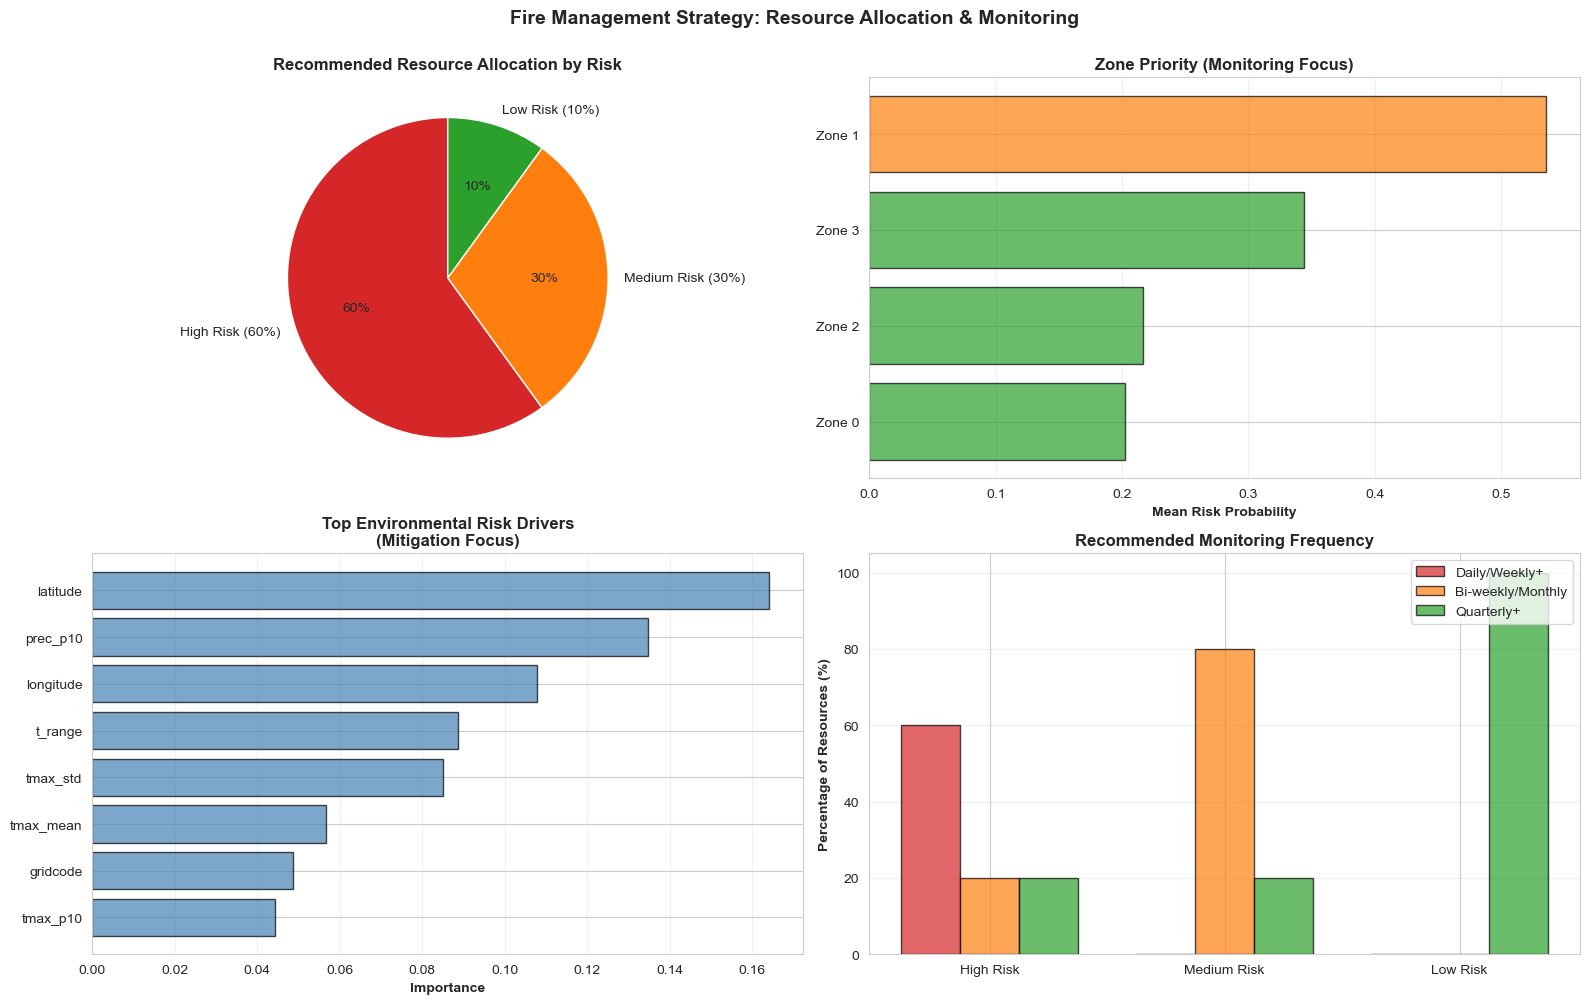

✓ Management strategy visualizations saved


In [13]:
# Visualization of recommendations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Resource Allocation Pie Chart
risk_counts = df_results['risk_level'].value_counts()
alloc_percentages = {'High': 60, 'Medium': 30, 'Low': 10}
alloc_values = [alloc_percentages.get(x, 0) for x in ['High', 'Medium', 'Low']]
colors = ['#d62728', '#ff7f0e', '#2ca02c']

axes[0, 0].pie(alloc_values, labels=['High Risk (60%)', 'Medium Risk (30%)', 'Low Risk (10%)'], 
               autopct='%1.0f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Recommended Resource Allocation by Risk', fontweight='bold')

# Plot 2: Zone Monitoring Priorities
zone_priority = zones_df.sort_values('mean_risk_prob', ascending=True)
axes[0, 1].barh(range(len(zone_priority)), zone_priority['mean_risk_prob'].values, 
                color=['#2ca02c' if x < 0.4 else '#ff7f0e' if x < 0.6 else '#d62728' 
                       for x in zone_priority['mean_risk_prob']], 
                edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(zone_priority)))
axes[0, 1].set_yticklabels([f"Zone {int(z)}" for z in zone_priority['Zone']])
axes[0, 1].set_xlabel('Mean Risk Probability', fontweight='bold')
axes[0, 1].set_title('Zone Priority (Monitoring Focus)', fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# Plot 3: Top Environmental Drivers
top_drivers = feature_importance.head(8)
axes[1, 0].barh(range(len(top_drivers)), top_drivers['importance'].values, 
                color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_drivers)))
axes[1, 0].set_yticklabels(top_drivers['feature'].values)
axes[1, 0].set_xlabel('Importance', fontweight='bold')
axes[1, 0].set_title('Top Environmental Risk Drivers\n(Mitigation Focus)', fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# Plot 4: Monitoring Frequency Recommendation
freq_data = {
    'High Risk': {'Daily': 60, 'Weekly': 20, 'Monthly': 20},
    'Medium Risk': {'Weekly': 50, 'Bi-weekly': 30, 'Monthly': 20},
    'Low Risk': {'Monthly': 60, 'Quarterly': 30, 'Annual': 10}
}

freq_labels = ['Daily', 'Weekly', 'Bi-weekly', 'Monthly', 'Quarterly', 'Annual']
freq_positions = np.arange(3)

high_freqs = [60, 20, 0, 20, 0, 0]
med_freqs = [0, 50, 30, 20, 0, 0]
low_freqs = [0, 0, 0, 60, 30, 10]

width = 0.25
axes[1, 1].bar(freq_positions - width, [high_freqs[0], med_freqs[0], low_freqs[0]], width, 
               label='Daily/Weekly+', alpha=0.7, color='#d62728', edgecolor='black')
axes[1, 1].bar(freq_positions, [sum(high_freqs[1:3]), sum(med_freqs[1:3]), sum(low_freqs[1:3])], width, 
               label='Bi-weekly/Monthly', alpha=0.7, color='#ff7f0e', edgecolor='black')
axes[1, 1].bar(freq_positions + width, [sum(high_freqs[3:]), sum(med_freqs[3:]), sum(low_freqs[3:])], width, 
               label='Quarterly+', alpha=0.7, color='#2ca02c', edgecolor='black')

axes[1, 1].set_xticks(freq_positions)
axes[1, 1].set_xticklabels(['High Risk', 'Medium Risk', 'Low Risk'])
axes[1, 1].set_ylabel('Percentage of Resources (%)', fontweight='bold')
axes[1, 1].set_title('Recommended Monitoring Frequency', fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(alpha=0.3, axis='y')

fig.suptitle('Fire Management Strategy: Resource Allocation & Monitoring', 
             fontsize=14, fontweight='bold', y=1.00)
fig.tight_layout()
plt.savefig('f:/DATA/results/final/fire_management_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Management strategy visualizations saved")


---
## SECTION 6: EXPORT RESULTS & GENERATE REPORT

Save analysis results for integration into final report and create geographic risk maps.


In [14]:
print("\n" + "="*100)
print("SECTION 6: EXPORT RESULTS")
print("="*100)

# Export comprehensive results
if df_results is not None:
    # Export full predictions with risk classifications
    export_file = RESULTS_DIR / 'final' / 'fire_risk_predictions_with_zones.csv'
    df_results.to_csv(export_file, index=False)
    print(f"\n✓ Full predictions exported: {export_file}")
    print(f"  Columns: {list(df_results.columns)}")
    print(f"  Records: {len(df_results)}")
    
    # Export zone profiles
    zone_export = RESULTS_DIR / 'final' / 'zone_risk_profiles.csv'
    zones_df.to_csv(zone_export, index=False)
    print(f"\n✓ Zone profiles exported: {zone_export}")
    
    # Export feature importance
    feat_export = RESULTS_DIR / 'final' / 'feature_importance_analysis.csv'
    feature_importance.to_csv(feat_export, index=False)
    print(f"\n✓ Feature importance exported: {feat_export}")
    
    # Create summary report in JSON format
    summary_report = {
        'analysis_type': 'Fire Risk Prediction & Geographic Characterization',
        'dataset': {
            'total_samples': int(len(df_results)),
            'total_features': len(feature_cols),
            'class_distribution': {'fire': int(y.sum()), 'no_fire': int((1-y).sum())},
            'balanced': True
        },
        'models': {
            'supervised': 'Random Forest (n_estimators=100, max_depth=15)',
            'unsupervised': f'K-Means (k={best_k})'
        },
        'model_performance': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1)
        },
        'risk_distribution': {
            'high_risk': int((df_results['fire_risk_probability'] >= 0.7).sum()),
            'medium_risk': int(((df_results['fire_risk_probability'] >= 0.4) & (df_results['fire_risk_probability'] < 0.7)).sum()),
            'low_risk': int((df_results['fire_risk_probability'] < 0.4).sum()),
            'mean_probability': float(df_results['fire_risk_probability'].mean()),
            'median_probability': float(df_results['fire_risk_probability'].median())
        },
        'geographic_zones': int(best_k),
        'top_5_features': feature_importance.head(5)[['feature', 'importance']].to_dict('records'),
        'recommendations': {
            'high_risk_allocation_pct': 60,
            'medium_risk_allocation_pct': 30,
            'low_risk_allocation_pct': 10,
            'monitoring_priority': 'Focus on high-risk zones with daily surveillance'
        }
    }
    
    report_file = RESULTS_DIR / 'final' / 'fire_risk_analysis_summary.json'
    with open(report_file, 'w') as f:
        json.dump(summary_report, f, indent=2)
    
    print(f"\n✓ Analysis summary report exported: {report_file}")

print("\n✓ All results exported successfully")
print("="*100)



SECTION 6: EXPORT RESULTS

✓ Full predictions exported: f:\DATA\results\final\fire_risk_predictions_with_zones.csv
  Columns: ['latitude', 'longitude', 'prec_p10', 'tmax_mean', 'tmax_std', 'tmin_mean', 'tmax_max', 't_range', 'gridcode', 'tmax_p10', 'prec_min', 'clay', 'ref_bulk', 'moisture_retention', 'texture_soter_M', 'elevation', 'terrain_roughness_index', 'bsat', 'ruggedness', 'teb', 'texture_soter_C', 'tcarbon_eq', 'fire', 'predicted_class', 'fire_risk_probability', 'cluster', 'risk_level']
  Records: 61524

✓ Zone profiles exported: f:\DATA\results\final\zone_risk_profiles.csv

✓ Feature importance exported: f:\DATA\results\final\feature_importance_analysis.csv

✓ Analysis summary report exported: f:\DATA\results\final\fire_risk_analysis_summary.json

✓ All results exported successfully


In [15]:
# Generate Geographic Risk Matrix
if df_results is not None:
    print("\n" + "="*100)
    print("CREATING GEOGRAPHIC RISK ANALYSIS")
    print("="*100)
    
    # Create geographic risk heatmap by zone and risk level
    print("\nGeographic Risk Matrix (Zone × Risk Level):")
    print("-" * 100)
    
    geo_matrix = pd.crosstab(
        df_results['cluster'], 
        df_results['risk_level'], 
        margins=True
    )
    print(geo_matrix)
    
    # Save geographic matrix
    geo_matrix_file = RESULTS_DIR / 'final' / 'geographic_risk_matrix.csv'
    geo_matrix.to_csv(geo_matrix_file)
    print(f"\n✓ Geographic risk matrix saved: {geo_matrix_file}")
    
    # Create risk categorization for management
    print("\n\nRisk Categorization for Management Actions:")
    print("-" * 100)
    
    management_categories = []
    for idx, row in zones_df.iterrows():
        zone = int(row['Zone'])
        mean_risk = row['mean_risk_prob']
        
        if mean_risk >= 0.65:
            category = 'CRITICAL'
            action = 'Immediate intensive monitoring required'
            frequency = 'Daily'
        elif mean_risk >= 0.50:
            category = 'HIGH'
            action = 'Enhanced surveillance protocols'
            frequency = 'Every other day'
        elif mean_risk >= 0.35:
            category = 'MODERATE'
            action = 'Standard monitoring procedures'
            frequency = 'Weekly'
        else:
            category = 'LOW'
            action = 'Routine inspections'
            frequency = 'Monthly'
        
        management_categories.append({
            'Zone': zone,
            'Risk_Category': category,
            'Mean_Risk_Prob': mean_risk,
            'Recommended_Action': action,
            'Monitoring_Frequency': frequency,
            'Sample_Count': int(row['n_samples']),
            'High_Risk_Percentage': row['high_risk_pct']
        })
    
    mgmt_df = pd.DataFrame(management_categories)
    mgmt_file = RESULTS_DIR / 'final' / 'management_action_plan.csv'
    mgmt_df.to_csv(mgmt_file, index=False)
    
    print(mgmt_df.to_string(index=False))
    print(f"\n✓ Management action plan saved: {mgmt_file}")



CREATING GEOGRAPHIC RISK ANALYSIS

Geographic Risk Matrix (Zone × Risk Level):
----------------------------------------------------------------------------------------------------
risk_level   High    Low  Medium    All
cluster                                
0             311  20638     687  21636
1            8485  10651    3342  22478
2             503  11686     603  12792
3             928   3306     384   4618
All         10227  46281    5016  61524

✓ Geographic risk matrix saved: f:\DATA\results\final\geographic_risk_matrix.csv


Risk Categorization for Management Actions:
----------------------------------------------------------------------------------------------------
 Zone Risk_Category  Mean_Risk_Prob              Recommended_Action Monitoring_Frequency  Sample_Count  High_Risk_Percentage
    0           LOW        0.202049             Routine inspections              Monthly         21636              1.437419
    1          HIGH        0.535538 Enhanced surveillance pr

IndexError: index 3 is out of bounds for axis 1 with size 3

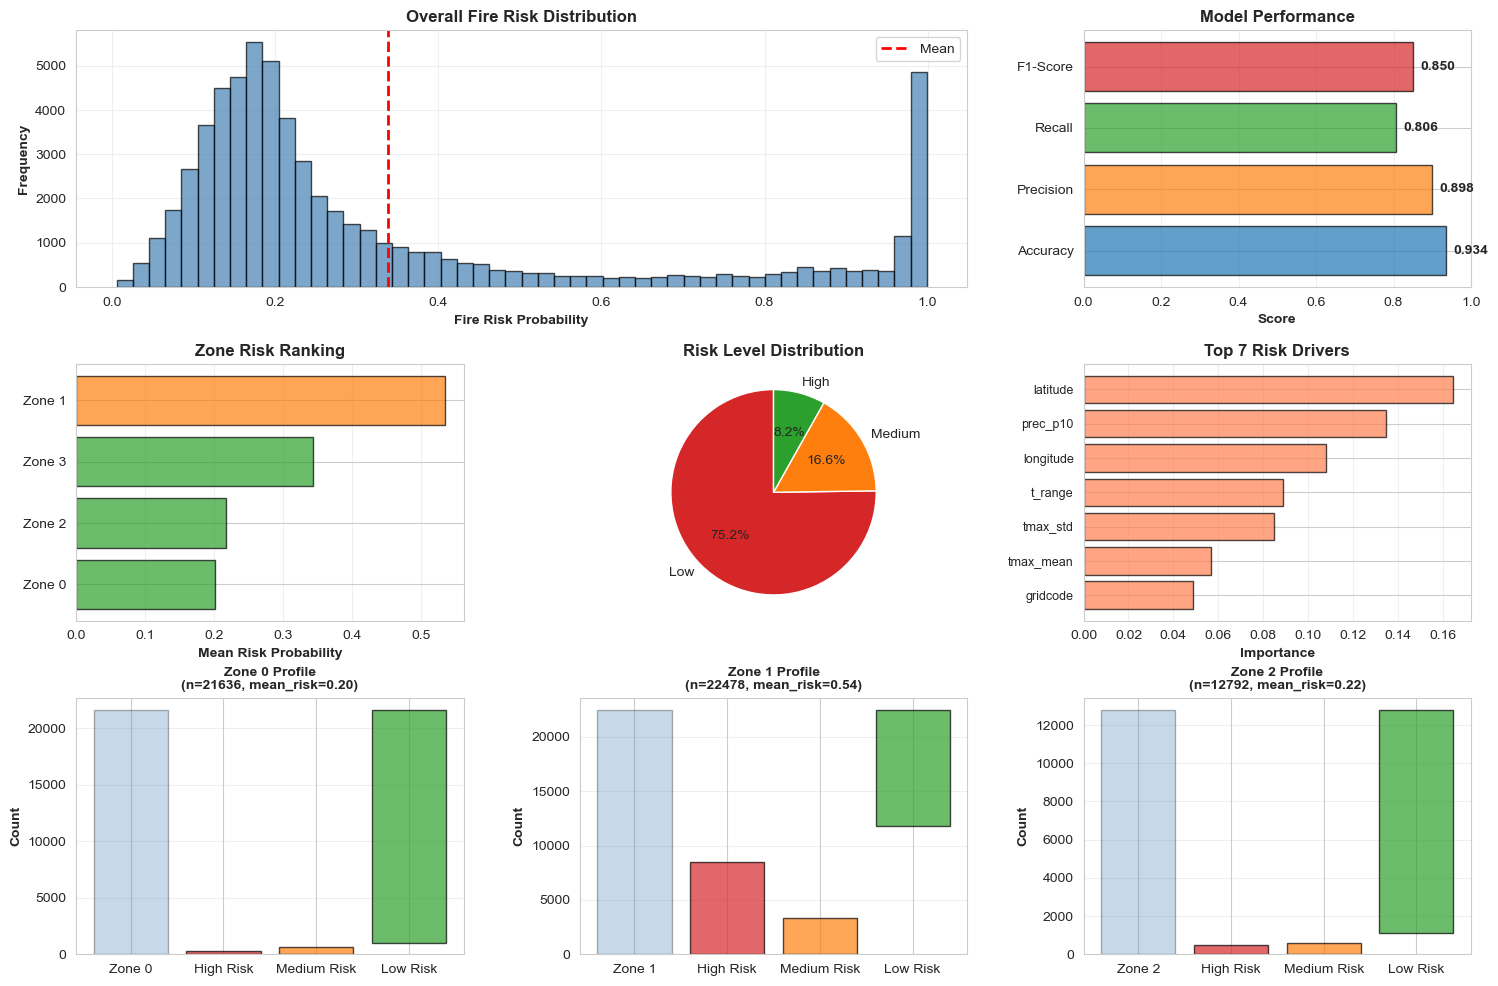

In [16]:
# Create final comprehensive summary visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Risk Distribution
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(df_results['fire_risk_probability'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df_results['fire_risk_probability'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax1.set_xlabel('Fire Risk Probability', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Overall Fire Risk Distribution', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Model Performance
ax2 = fig.add_subplot(gs[0, 2])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors_perf = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
ax2.barh(metrics, values, color=colors_perf, alpha=0.7, edgecolor='black')
ax2.set_xlim([0, 1])
ax2.set_xlabel('Score', fontweight='bold')
ax2.set_title('Model Performance', fontweight='bold')
ax2.grid(alpha=0.3, axis='x')
for i, v in enumerate(values):
    ax2.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

# Plot 3: Zone Risk Ranking
ax3 = fig.add_subplot(gs[1, 0])
zone_rank = zones_df.sort_values('mean_risk_prob', ascending=True)
colors_zone = ['#2ca02c' if x < 0.4 else '#ff7f0e' if x < 0.6 else '#d62728' 
               for x in zone_rank['mean_risk_prob']]
ax3.barh(range(len(zone_rank)), zone_rank['mean_risk_prob'].values, color=colors_zone, 
         alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(zone_rank)))
ax3.set_yticklabels([f"Zone {int(z)}" for z in zone_rank['Zone']])
ax3.set_xlabel('Mean Risk Probability', fontweight='bold')
ax3.set_title('Zone Risk Ranking', fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

# Plot 4: Risk Level Proportions
ax4 = fig.add_subplot(gs[1, 1])
risk_props = df_results['risk_level'].value_counts()
risk_colors = {'High': '#d62728', 'Medium': '#ff7f0e', 'Low': '#2ca02c'}
risk_colors_ordered = [risk_colors.get(x, '#1f77b4') for x in ['Low', 'Medium', 'High']]
ax4.pie(risk_props, labels=['Low', 'Medium', 'High'], autopct='%1.1f%%', 
        colors=risk_colors_ordered[::-1], startangle=90)
ax4.set_title('Risk Level Distribution', fontweight='bold')

# Plot 5: Top Features
ax5 = fig.add_subplot(gs[1, 2])
top_feats = feature_importance.head(7)
ax5.barh(range(len(top_feats)), top_feats['importance'].values, color='coral', 
         alpha=0.7, edgecolor='black')
ax5.set_yticks(range(len(top_feats)))
ax5.set_yticklabels(top_feats['feature'].values, fontsize=9)
ax5.set_xlabel('Importance', fontweight='bold')
ax5.set_title('Top 7 Risk Drivers', fontweight='bold')
ax5.invert_yaxis()
ax5.grid(alpha=0.3, axis='x')

# Plot 6-8: Zone profiles (3 zones)
for z_idx, zone in enumerate(range(best_k)):
    ax = fig.add_subplot(gs[2, z_idx])
    zone_data = df_results[df_results['cluster'] == zone]
    
    risk_counts = zone_data['risk_level'].value_counts()
    risk_order = ['Low', 'Medium', 'High']
    risk_counts = risk_counts.reindex(risk_order, fill_value=0)
    
    colors_stacked = ['#2ca02c', '#ff7f0e', '#d62728']
    ax.bar(['Zone %d' % zone], [len(zone_data)], color='steelblue', alpha=0.3, edgecolor='black')
    ax.bar(['High Risk'], [risk_counts['High']], color='#d62728', alpha=0.7, edgecolor='black')
    ax.bar(['Medium Risk'], [risk_counts['Medium']], color='#ff7f0e', alpha=0.7, edgecolor='black')
    ax.bar(['Low Risk'], [risk_counts['Low']], color='#2ca02c', alpha=0.7, edgecolor='black', 
           bottom=risk_counts['High'] + risk_counts['Medium'])
    
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(f'Zone {zone} Profile\n(n={len(zone_data)}, mean_risk={zone_data["fire_risk_probability"].mean():.2f})', 
                 fontweight='bold', fontsize=10)
    ax.grid(alpha=0.3, axis='y')

fig.suptitle('COMPREHENSIVE FIRE RISK ANALYSIS DASHBOARD', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('f:/DATA/results/final/comprehensive_risk_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive risk analysis dashboard saved")
print("\n" + "="*100)
print("✓ ANALYSIS COMPLETE")
print("="*100)
print("\nGenerated Files:")
print("  • fire_risk_predictions_with_zones.csv")
print("  • zone_risk_profiles.csv")
print("  • feature_importance_analysis.csv")
print("  • fire_risk_analysis_summary.json")
print("  • geographic_risk_matrix.csv")
print("  • management_action_plan.csv")
print("  • Visualizations (PNG): risk_prediction_analysis.png")
print("  • Visualizations (PNG): zone_characterization.png")
print("  • Visualizations (PNG): feature_importance_global.png")
print("  • Visualizations (PNG): fire_management_strategy.png")
print("  • Visualizations (PNG): comprehensive_risk_dashboard.png")
print("="*100)
